# Baht Coin Detection using Computer Vision

## Introduction

According to IBM : "Computer vision is a field of artificial intelligence (AI) that uses machine learning and neural networks to teach computers and systems to derive meaningful information from digital images, videos and other visual inputs—and to make recommendations or take actions when they see defects or issues."

For a computer and image is just a matrix of pixels. If we consider the RGB format that each pixel is a tuple of three value ranging from 0 to 255, each representing one of the fundamental colors. Humans are very good to analyze images and extract miningfull informations from them. Let's say we have a bunch of coins dispached on a table. It takes us a fraction of a second to distinguish each coins from the background. Computer can't see the same way we do. computer can use convolution layers to extract features usefull for object recognition such as edges for exemple. Let's take a look at what it looks like with different simple kernel :

In [6]:
%matplotlib inline
import ultralytics
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

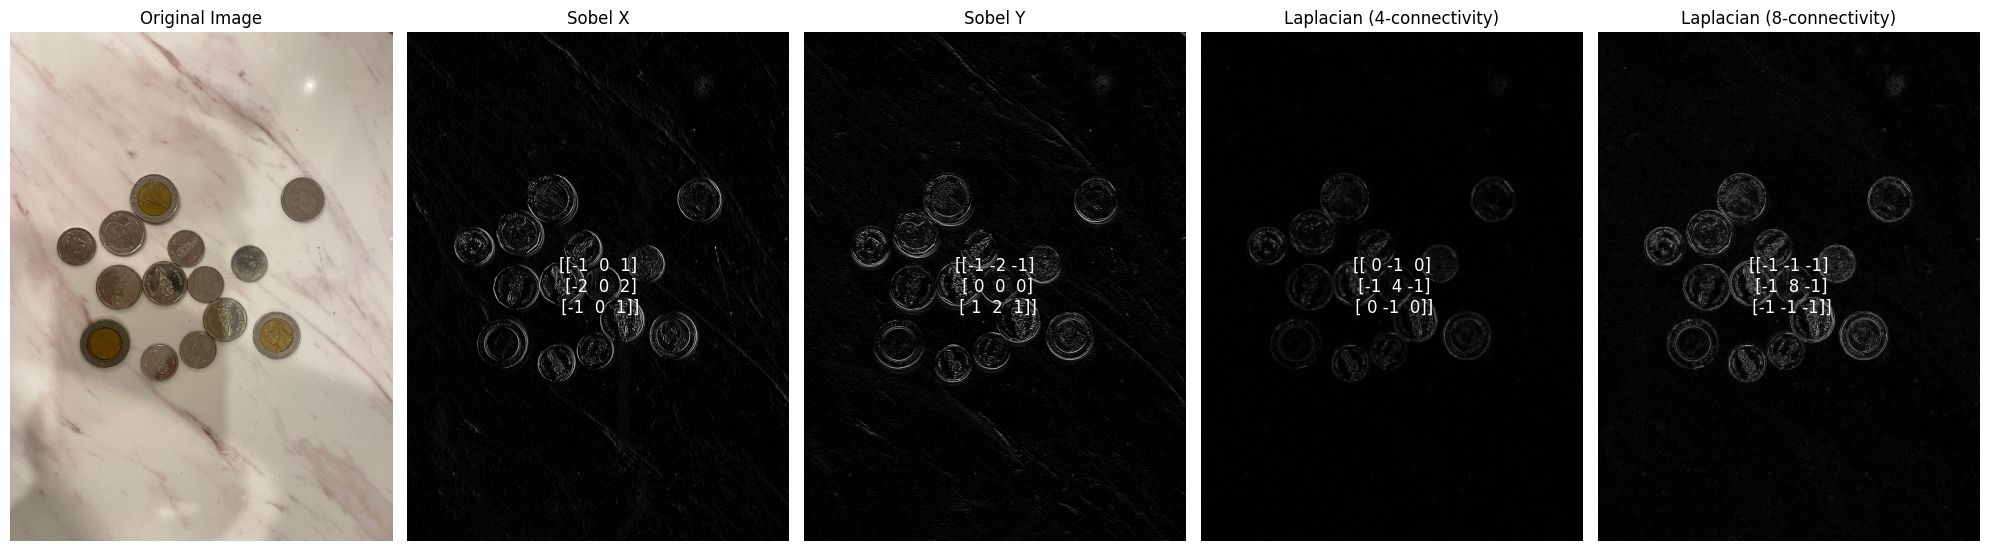

In [20]:
def display_image_with_kernels(image_path):
    # Load the image using Pillow
    original_image = Image.open(image_path)
    open_cv_image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    
    # Define the kernels
    sobel_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    laplacian_4_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    laplacian_8_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

    # Apply Sobel filter in x and y directions
    sobel_x = cv2.filter2D(gray_image, -1, sobel_x_kernel)
    sobel_y = cv2.filter2D(gray_image, -1, sobel_y_kernel)
    
    # Apply Laplacian filter
    laplacian_4 = cv2.filter2D(gray_image, -1, laplacian_4_kernel)
    laplacian_8 = cv2.filter2D(gray_image, -1, laplacian_8_kernel)
    
    # Set up the plot
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(sobel_x, cmap="gray")
    axes[1].set_title("Sobel X")
    axes[1].axis("off")
    axes[1].text(0.5, 0.5, str(sobel_x_kernel), color='white', fontsize=12, ha='center', va='center', transform=axes[1].transAxes)

    axes[2].imshow(sobel_y, cmap="gray")
    axes[2].set_title("Sobel Y")
    axes[2].axis("off")
    axes[2].text(0.5, 0.5, str(sobel_y_kernel), color='white', fontsize=12, ha='center', va='center', transform=axes[2].transAxes)
    
    axes[3].imshow(laplacian_4, cmap="gray")
    axes[3].set_title("Laplacian (4-connectivity)")
    axes[3].axis("off")
    axes[3].text(0.5, 0.5, str(laplacian_4_kernel), color='white', fontsize=12, ha='center', va='center', transform=axes[3].transAxes)
    
    axes[4].imshow(laplacian_8, cmap="gray")
    axes[4].set_title("Laplacian (8-connectivity)")
    axes[4].axis("off")
    axes[4].text(0.5, 0.5, str(laplacian_8_kernel), color='white', fontsize=12, ha='center', va='center', transform=axes[4].transAxes)
    
    plt.tight_layout()

# Example usage
display_image_with_kernels('test_YOLO2.jpg')


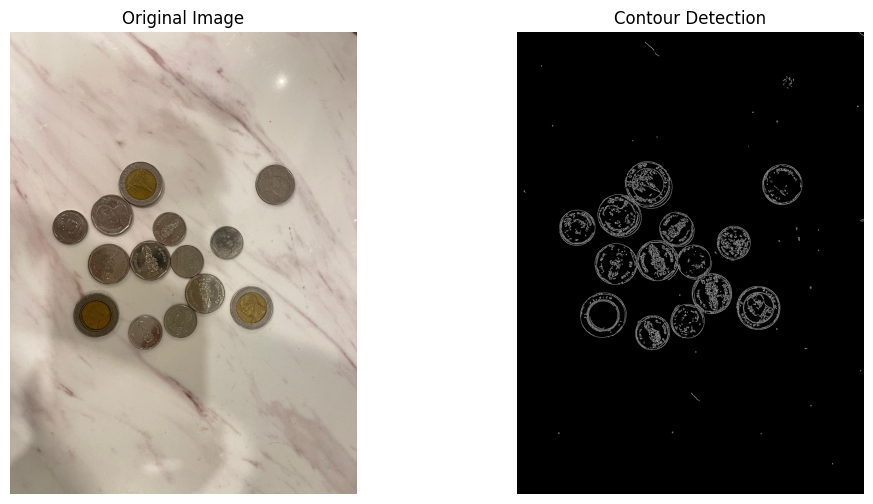

In [10]:
def display_image_with_contour(image_path):
    original_image = Image.open(image_path)
    gray_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
    contour_image = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(contour_image, cmap="gray")
    axes[1].set_title("Contour Detection")
    axes[1].axis("off")
display_image_with_contour("test_YOLO2.jpg")

Here is Canny Edge Detection algorithm which uses a combination of kernel and other enginnering technique for better edge detection :
1. Noise Reduction (Gaussian Blur).
2. Gradient Calculation (Sobel X and Y, Gradient Magnitude and Direction).
3. Non-Maximum Suppression (Thinning edges).
4. Double Thresholding (Classify edges as strong, weak, or non-edge).
5. Edge Tracking by Hysteresis (Retain only relevant edges).

## Project Overview

During my exchange program in Thaildand (2024) I noticed how hard it was too spend my coins. While buying grocerie I always got a lot of coins as change. I rarely spend them as most of my expenses are higer than 20 baht wich is the smallest Banknote available. I ended up stacking coins on my desk, especially one baht coin and the pile kept growing. I was making me unconfortable to pay a meal with a handful of coins and to force the cashier to count them all. Some big store have automatic cashier and machines to automatically count coins but those are expensive device wich are not suitable for most shop and thai street food restaurant. Imagining beeing able to dispatch coins on the counter, take a picture and get the total baht value on it ! This is the goal I will try to achieve for this project. Even though I found models online that claims to have a 90% precison to classify baht coins I think they are overfitting. Indeed the result I got testing the different models with my own pictures where around 40%. Off course if my model doesn't have a good enough precision it won't be useable in practice. I'm pretty confident that coin detection will work pretty well. Has cashier sort coins in different boxes during the day the model could count each of them. instead of counting hundreds of coin the cashier will only have to multyply the number of coin to their value. 

Baht coins are very hard to identify has the 1,2 and 5 baht coins look very similiar. Each one of them as the king's face on one side which make the disction very hard. People usually refers on extra informations such as size, comparaison or the possibility to flip the coin to be sure of its value. A model can't obviously do that last technique. It can neither rely on the coins' size as scale can't be captured. 

I first tried to train a faster R-CNN network which made me realize multiple things that I will explain later on. This trial made me realize that my ASUS Vivobook was nowhere close to meet the requirement to train big network. My laptop has an Intel® Iris® Xe GPU which can't be used to train the model. The reason is that PyTorch only support CUDA architecture which is NVIDIA-Specific. As a result the model is trained on my Intel® Core™ i7. CPU are not suitable for machine learning has they are designed for sequential processing, lower memory bandwidth and the list goes on. I tried to train the faster R-CNN model on it and I had to stop the training. The reason is that after 2h of calcultations I didn't finished the first epoch and the dataset was less than 10 000 images long. I switched to google colab and their free T4 GPU plan. I sucedded to complete the 10 epoch long training in 52min but used all the free plan credits. This is not enough and I had to suscribe to get access to a A100 GPU.

Tools and code not present in this notebook are availbale on my github : 

# R-CNN

R-CNN (Region-based Convolutional Neural Network) is a deep learning architecture that combines region proposals with convolutional neural networks. The region proposal layer returns bounding boxes that are likely to contain objects. Then a CNN (Convolutional Neural Network) operates features extraction and return an output feature vector for every region. After that an SVM (Support Vector Machine) determine wether or not a region belong to one specific categorie using a one-vs-all SVM classifiers. To finish a bounding box regressor is applied to better fit the object. To sum up the R-CNN pipeline is the folowwing : 
1. Input
2. Region Proposal (Selective Search)
3. Feature Extraction (CNN)
4. Classification (SVM for each class)
5. Bounding Box Refinement (Bounding box regression)
6. Output

## Fist trial

For the first training of my model I made severall mistakes. First I didn't understand that R-CNN network has it's own image preprocessing pipeline. As I knew every image should match the chosen input layeer's size I resized it using 'torchvision.transforms.Resize(128,128)'. The issue is that proportion are not preserved which increases complexity to extract miningfull data geometrical shapes. As faster R-CNN relies on a RPN (Region Proposal Network) to extract intresting areas in the image it doesn't need a fixed sized input layer. Therefore the preprocessing pipeline resizes the image according to the biggest edge to make it fit within a specific range and preserve ratio on the resized image. Due to computational limitations I also picked a way too little size for the input layer (128*128). Due to resizing most pixel where lost and coins could no longer be differenciate, even for a human.

To train this model I used the following dataset : https://universe.roboflow.com/thaibank/thaibath-detection/dataset/3

In [27]:
def display_original_and_resized(image_path, new_size=(128, 128)):
    original_image = Image.open(image_path)
    resized_image = original_image.resize(new_size)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(resized_image)
    axes[1].set_title(f"Resized Image ({new_size[0]}x{new_size[1]})")
    axes[1].axis("off")

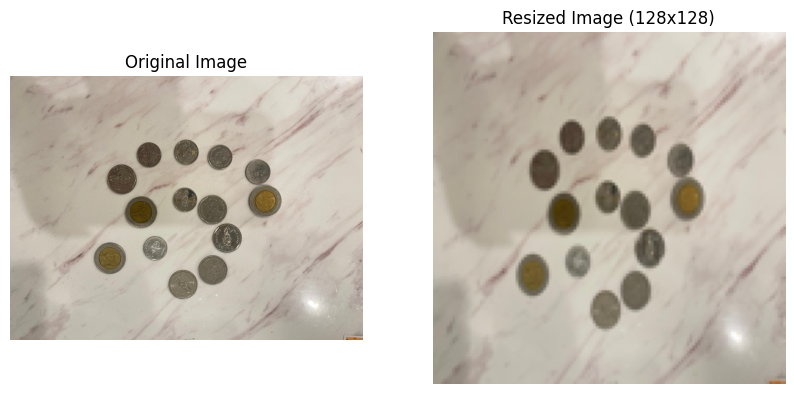

In [31]:
display_original_and_resized("C:/Users/romai/OneDrive - De Vinci/Bureau/CoinsAI/baht_dataset_horizontal/images/5de2f823-baht_d8.jpg")

An other mistake I made is making all the calculations to resize box according to the new image dimensions despite the fact that the model already does it. I trained a pretrained model for 10 epoch, with an input layer of 128 by 128 and a frozen backbone. Here is the result :

In [10]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import torch
from PIL import Image,ImageDraw

def show_result(image_path, predictions, config, confidence_threshold):
    # Open the original image
    original_image = Image.open(image_path)
    original_width, original_height = original_image.size
    
    # Calculate resizing factors for width and height
    scale_x = original_width / config.img_width
    scale_y = original_height / config.img_height

    draw = ImageDraw.Draw(original_image)

    # Extract labels, bounding boxes, and scores from predictions
    labels = predictions[0]['labels'].tolist()
    scores = predictions[0]['scores'].tolist()
    labels = [str(l) for l in labels]
    
    # Adjust and draw bounding boxes
    n = 0
    for i, (box, score) in enumerate(zip(predictions[0]['boxes'], scores)):
        if score >= confidence_threshold:
            n += 1
            xmin, ymin, xmax, ymax = box

            # Scale the bounding box coordinates
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            
            colors = ["blue", "green", "red", "yellow", "purple", "orange"]
            color = colors[i % len(colors)]
            draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)
        
    print(n, "objects detected with confidence level higher than", confidence_threshold)
        
    plt.imshow(original_image)
    plt.axis('off')

class Config:
    def __init__(self):
        self.num_epochs = 10
        self.unfrezed_epoch = 15
        self.img_width = 128
        self.img_height = 128
        
def rcnn_prediction(config,image_path,confidence_threshold=0.5,model_path="models/dummy_faster_rcnn.pth"):
    config = Config()
    num_class = 4 + 1 # Add 1 for the background class
    model = fasterrcnn_resnet50_fpn(num_classes=num_class)
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu'))) # cpu due to my hardware limitations
    model.eval()

    transform = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor(),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        predictions = model(image)

    show_result(image_path,predictions,config,confidence_threshold=confidence_threshold)

In [11]:
config_rcnn = Config()

30 objects detected with confidence level higher than 0.1


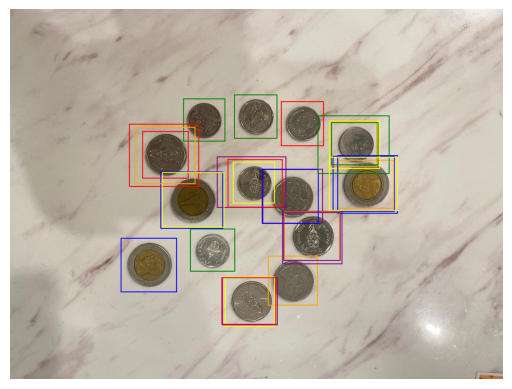

In [12]:
rcnn_prediction(config_rcnn,confidence_threshold=0.1,image_path="baht_dataset_horizontal/images/5de2f823-baht_d8.jpg")

We notice that all the bounding boxs contain a coin which is a good result. Multiple bounding box contain the same object which could be corrected using non max supression.

14 objects detected with confidence level higher than 0.5


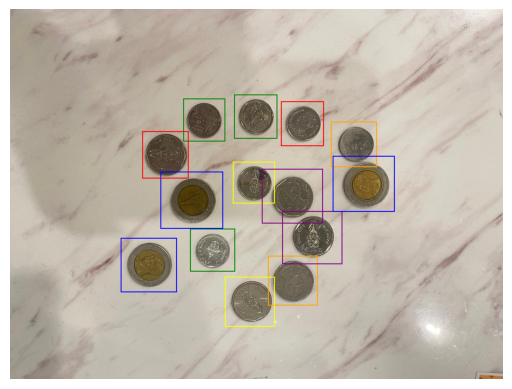

In [62]:
rcnn_prediction(config_rcnn,confidence_threshold=0.5,image_path="baht_dataset_horizontal/images/5de2f823-baht_d8.jpg")

By increasing the confidence level treshold we get rid of most of the bounding box and only one per coin remain. This is very promising as our dummy model succeded to count the number of coin on the image on this particular exemple. The model classified correctly all of the 10 baht coin. It means that the 10 baht coin SVM should be already quite performant. For the other coins the result as very bad.

We didn't saved the performance of our model and won't spend time running the test again as based on the previous example we can tell that the model has a very low accuracy.

## Dataset Processing

Jupyther notebook are not very suitable when it comes to import different class from other files that are regularely updated. This is why we processed it outside of this notebook. We will provide at the end all the code used to process the dataset.   

I labelled 1655 bounding boxs on 54 images to constitute my dataset. For obvious reason I couldn't spent more than severall hours to labbel each of them by hand. I then splitted the dataset into train, set and valid with the following proportions 0.8, 0.1 and 0.1.


In order to get a dataset big enough to train our Yolo model I also dowloaded the folowing dataset online : https://universe.roboflow.com/cherry-bnrg6/thb-currency-counter/dataset/13 which has already been preproceed by a data augmentation algorithm according to the following configuration :
1. Outputs per training example: 3
2. 90° Rotate: Clockwise, Counter-Clockwise, Upside Down
3. Rotation: Between -45° and +45°
4. Brightness: Between -41% and +41%
5. Exposure: Between -12% and +12%
6. Noise: Up to 3% of pixels

I augmented mt own dataset on Roboflow using the same setting except rotation : -15° and + 15° and noise 0.3%.

The dataset I created is using the YOLOv8 Oriented Bounding Boxes format wether the one I downloaded is using the default one. I made a function to make the format conversion, drop all the bounding box with a label different than the following 1,2,5 or 10 baht and make the corrrect index:label mapping in order to merge the two dataset. 

|              | Images | Bounding Boxes |
|-----------------|--------|----------------|
| **Train**       |  699   |      6918      |
| **Validation**  |   47   |       319      |
| **Test**        |   36   |       397      |


```python
from tools import Tools

new_index = {
    2:0,
    3:1,
    6:2,
    10:3
}
Tools.convert_yolo_to_obb('baht_dataset','baht_processed_dataset', new_index)


# YOLO

In [17]:
model = YOLO("models/yolov8n.pt")

Let's run the pretrained Yolo model on our coins :


0: 640x512 17 bowls, 2 oranges, 1 dining table, 187.3ms
Speed: 4.1ms preprocess, 187.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 512)


(np.float64(-0.5), np.float64(3471.5), np.float64(4623.5), np.float64(-0.5))

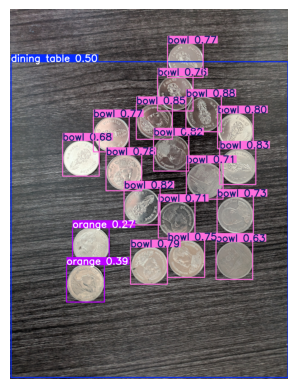

In [18]:
image_path = 'report_images/test_YOLO1.jpg'
img = cv2.imread(image_path)
results = model(img)
annotated_img = results[0].plot()
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis('off')


0: 640x480 (no detections), 192.9ms
Speed: 0.0ms preprocess, 192.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


(np.float64(-0.5), np.float64(1199.5), np.float64(1599.5), np.float64(-0.5))

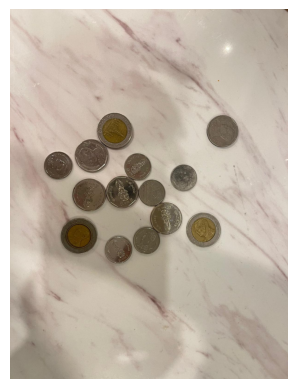

In [19]:
image_path = 'report_images/test_YOLO2.jpg'
img = cv2.imread(image_path)
results = model(img)
annotated_img = results[0].plot()
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

The results are intresting. For the human eye the two images are very similar and it is easy to identify coins. As coins isn't a labelled class used to train YOLO it is normal that it doesn't detect any of them. It is more surprising that it detects 0 object in the second one but 19 round shaped object in the first one. My guess is that the slight angle and the high luminosity in the fist photograph gives a volume impression to the model wheras the coins appers like disk in the second one. The very intresting result is that if you consider bowls and orange as coins we have 17+2=19 coins wich is the correct result. The model even succed to identify the background.

In [20]:
model2 = YOLO("models/yolov8s.pt")


0: 640x512 7 cups, 9 oranges, 2 cakes, 1 dining table, 263.2ms
Speed: 0.0ms preprocess, 263.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


(np.float64(-0.5), np.float64(3471.5), np.float64(4623.5), np.float64(-0.5))

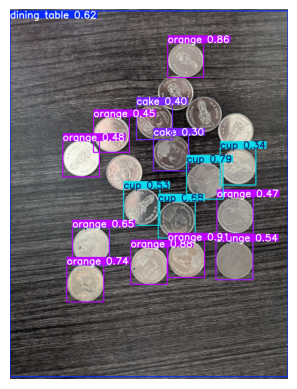

In [24]:
image_path = 'report_images/test_YOLO1.jpg'
img = cv2.imread(image_path)
results = model2(img)
annotated_img = results[0].plot()
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis('off')


0: 640x480 2 donuts, 1 cake, 260.5ms
Speed: 1.7ms preprocess, 260.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


(np.float64(-0.5), np.float64(1199.5), np.float64(1599.5), np.float64(-0.5))

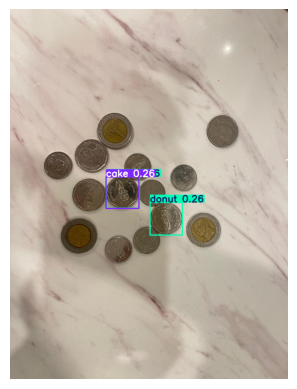

In [22]:
image_path = 'report_images/test_YOLO2.jpg'
img = cv2.imread(image_path)
results = model2(img)
annotated_img = results[0].plot()
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

In our first training of faster R-CNN we previously identified severall issues. First of all the Resize function we used didn't preserve aspect ratio. As a result if the training test contains images of various initial dimensions (which is our case) it is very hard to extract any geometrical feature. The YoloV8 preprocessing pipeline preserves the aspect ratio by using a combination of padding and resizing. An other reasons that   YoloV8 uses a biger input layer.

Based on online research I determined that Yolov8s (s for small) was the most suitable model to train for my use case. Indeed it as a good speed and accuracy trade of and can be trained with the computer power available with my collab subscribtion.

1. mesurer erreur par montant
2. mesurer erreur de détection par classe
3. mesurer erreur pour le comptage de pièces
4. perf avec plusieurs photo et moyenne

5. train avec mon dataset
6. train avec dataset online

